
# **Automatically classify consumer goods**

##***Supervised automatic classification of images***

*Place de marché* is a company that wants to launch an e-commerce marketplace.
Manual classification of items by sellers is unreliable and limited.

As a Data Scientist, I evaluated the feasibility of an automatic product classification system, using photos and descriptions. Here I will carry out supervised classification from the images and implement data augmentation in order to optimize the model.

*NB: The images and descriptions as well as all the data used here are public data available on the website of the company “Marketplace” and are not intellectual property.*

<u><strong>Summary</strong></u> :<br>
<br>
<strong>Tools</strong> <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=ad04d6df">(here)</a><br><br>
<strong>III. Supervised automatic classification of images</strong><br>
     -- A. Data preprocessing and encoding <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=f6165234">(here)</a><br>
     -- B. VGG16 <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=fMwdhRNPSX0Z">(here)</a><br>
     -- C. ResNet <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=mjAVZZE6Sevb">(here)</a><br>
     -- D. Inception <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=iShfrwcSMrAu">(here)</a><br>
     -- E. Basic and advanced data augmentation on ResNet model <a href="https://colab.research.google.com/drive/1jwn4iiLWJBd8AxwMqkpZKefY7Y4V6gvd#scrollTo=RMmMN5FEjIDS">(here)</a><br>

****

### **Tools**

In [ ]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import warnings
import time
import tensorflow as tf

from PIL import Image, ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras import layers, models
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.preprocessing import image as keras_image
from keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications.resnet import ResNet50
from keras.applications import EfficientNetB0
from keras.applications.inception_v3 import InceptionV3

from sklearn import cluster, metrics, manifold, decomposition
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn import cluster, metrics

from sklearn.manifold import TSNE
from sklearn import cluster, metrics
from sklearn.metrics import silhouette_score

In [ ]:
def split_column(df, column_name):
    """
    Split a DataFrame column into multiple columns using space as the separator.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the column to split.
    column_name (str): The name of the column to split.

    Returns:
    pandas.DataFrame: A DataFrame with the original column split into multiple columns.
    """
    if column_name in df.columns:
        new_cols = df[column_name].str.split(',', expand=True)
        # Rename the new columns
        new_cols.columns = [
            f"{column_name}_{i}" for i in range(new_cols.shape[1])
        ]
        # Concatenate the new columns to the original DataFrame
        df = pd.concat([df, new_cols], axis=1)
    else:
        print(f"Column '{column_name}' not found in DataFrame.")

    return df

In [ ]:
def load_model(pretrained_model):
    if pretrained_model == 'vgg16':
        return VGG16(weights="imagenet",
                     include_top=False,
                     input_shape=data_vgg['img'][0].shape)
    elif pretrained_model == 'resnet':
        return ResNet50(weights="imagenet",
                        include_top=False,
                        input_shape=data_vgg['img'][0].shape)
    elif pretrained_model == 'inception':
        return InceptionV3(weights="imagenet",
                           include_top=False,
                           input_shape=data_vgg['img'][0].shape)
    elif pretrained_model == 'efficientnet':
        return EfficientNetB0(weights="imagenet",
                              include_top=False,
                              input_shape=data_vgg['img'][0].shape)

In [ ]:
def ARI_fct(features, N_CLUSTERS, encode_cat, perplexity=20):
    time1 = time.time()
    num_labels = len(l_cat)
    tsne = manifold.TSNE(n_components=2,
                         perplexity=perplexity,
                         n_iter=2000,
                         init='random',
                         learning_rate=200,
                         random_state=42)
    X_tsne = tsne.fit_transform(features)
    cls = cluster.KMeans(n_clusters=N_CLUSTERS, n_init=200, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(encode_cat, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)

    return ARI, X_tsne, cls.labels_


def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))

    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=l_cat,
              loc="best",
              title="Categorie")
    plt.title('Representation of actual product categories')

    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0],
              labels=set(labels),
              loc="best",
              title="Clusters")
    plt.title('Representation of product categories by clusters')

    plt.show()
    print("ARI : ", ARI)


# Match kmeans clusters with true clusters
def clusters_matching(cat_true, cat_kmeans):
    conf_mat = confusion_matrix(cat_true, cat_kmeans)
    print(conf_mat)
    print()
    corresp = np.argmax(conf_mat, axis=0)
    print(corresp)
    labels = pd.Series(cat_true, name="cat_true").to_frame()
    labels['cat_kmeans'] = cat_kmeans
    labels['y_kmeans_transform'] = labels['cat_kmeans'].apply(
        lambda x: corresp[x])

    return labels['y_kmeans_transform']


def confusion_matrix_plot(y_true, y_pred, categories):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=categories)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.setp(ax.get_xticklabels(),
             rotation=45,
             ha="right",
             rotation_mode="anchor")
    disp.plot(xticks_rotation=55, ax=ax, cmap=plt.cm.Blues)


def pca_(X):
    N_COMP = 70
    pca = PCA(n_components=N_COMP)
    X_pca = pca.fit_transform(X)
    return X_pca



---



## **I.Supervised automatic classification of images**

### **A. Data preprocessing and encoding**

In [ ]:
data = pd.read_csv(
    "/content/drive/MyDrive/flipkart_com-ecommerce_sample_1050.csv", sep=",")
data.shape

(1050, 15)

In [ ]:
# New df
data = data[["uniq_id", "product_category_tree", "image"]]
data.head()

,uniq_id,product_category_tree,image
0,55b85ea15a1536d46b7190ad6fff8ce7,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",6325b6870c54cd47be6ebfbffa620ec7.jpg


In [ ]:
# Removing special characters from the "product_category_tree" column
data['product_category_tree'] = data['product_category_tree'].str.replace(
    ">>", ",", regex=True)

# Call function to split column 'product_category_tree' of DataFrame 'data'
data = split_column(data, 'product_category_tree')
data['product_category_tree_0'] = data['product_category_tree_0'].astype(str)

# Remove special character
data['category'] = data['product_category_tree_0'].str.replace(
    "\['", "").str.replace("\W+", " ", regex=True).str.strip()

# Final df
data = data[["uniq_id", "category", "image"]]
data.head()

,uniq_id,category,image
0,55b85ea15a1536d46b7190ad6fff8ce7,Home Furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,7b72c92c2f6c40268628ec5f14c6d590,Baby Care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,64d5d4a258243731dc7bbb1eef49ad74,Baby Care,64d5d4a258243731dc7bbb1eef49ad74.jpg
3,d4684dcdc759dd9cdf41504698d737d8,Home Furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
4,6325b6870c54cd47be6ebfbffa620ec7,Home Furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg


In [ ]:
data.category.unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor Festive Needs', 'Kitchen Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [ ]:
# Encoding categories
encode_fast = {
    'Home Furnishing': 0,
    'Baby Care': 1,
    'Watches': 2,
    'Home Decor Festive Needs': 3,
    'Kitchen Dining': 4,
    'Beauty and Personal Care': 5,
    'Computers': 6
}
data['encode_cat'] = data['category'].map(encode_fast)

In [ ]:
image_directory = '/content/drive/MyDrive/pix/'

data_img = pd.DataFrame({'unique_id': [], 'img': []})
a = []
b = []
for file_name in os.listdir(image_directory):
    a.append(file_name.split('.')[0])
    b.append(np.array(Image.open(image_directory + file_name)))
data_img['unique_id'] = a
data_img['img'] = b

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
data_img.head(2)

,unique_id,img
0,0e73201f6d8807776e1d21c969078289,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."
1,3c4604dba348a99a2dfbbc2cd3928101,"[[[255, 255, 255], [255, 255, 255], [255, 255,..."


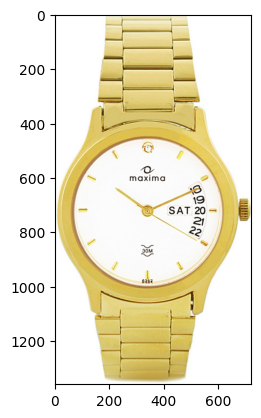

In [ ]:
to_show = np.random.choice(list(data_img.unique_id))
plt.imshow(data_img[data_img.unique_id == to_show]['img'].item())

In [ ]:
def get_cat(unique_id):
    return data[data['uniq_id'] == unique_id]['category'].item()


data_img['category'] = data_img.unique_id.apply(lambda x: get_cat(x))
data_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1049 entries, 0 to 1048
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   unique_id  1049 non-null   object
 1   img        1049 non-null   object
 2   category   1049 non-null   object
dtypes: object(3)
memory usage: 24.7+ KB


In [ ]:
data_img['category_encoded'] = data_img['category'].map(encode_fast)

In [ ]:
data_img.head()

,unique_id,img,category,category_encoded
0,0e73201f6d8807776e1d21c969078289,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Kitchen Dining,4
1,3c4604dba348a99a2dfbbc2cd3928101,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Beauty and Personal Care,5
2,3ccceaae844f34180708cb6cba3441bf,"[[[254, 254, 254], [253, 253, 253], [253, 253,...",Computers,6
3,1be8161a259813bca5d068d5730464e7,"[[[250, 251, 255], [250, 251, 255], [249, 250,...",Beauty and Personal Care,5
4,2cc24452688ed35dfbff566e22e53c95,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",Beauty and Personal Care,5


Home Decor Festive Needs


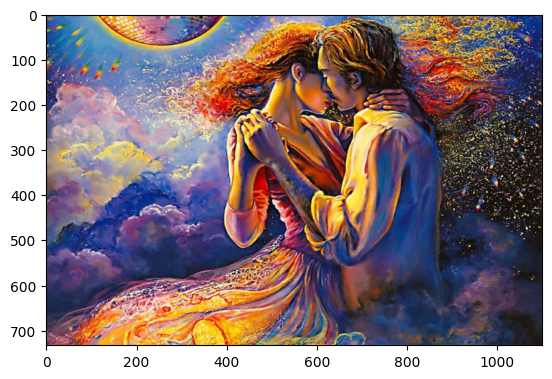

Watches


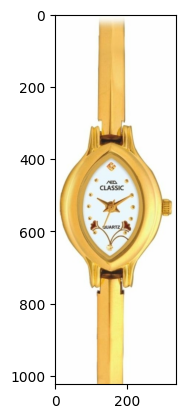

Kitchen Dining


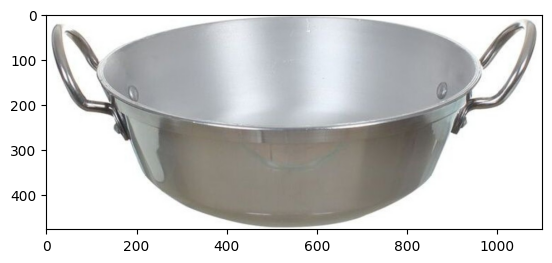

Beauty and Personal Care


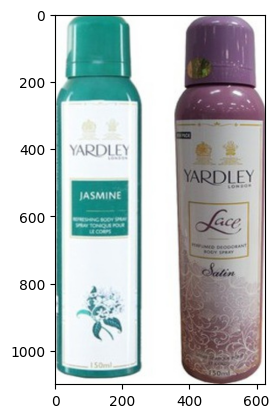

Computers


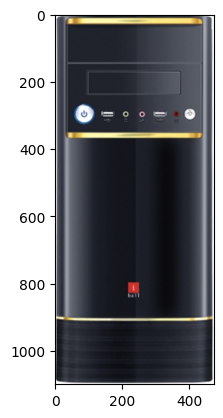

Home Furnishing


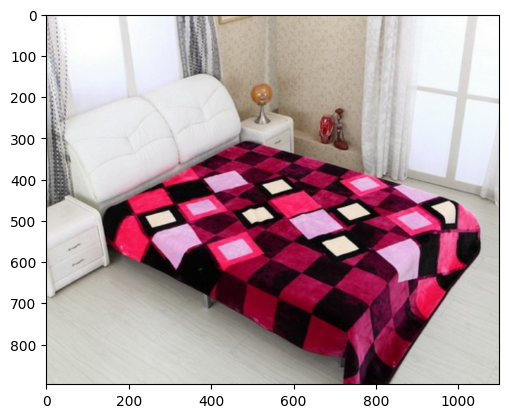

Baby Care


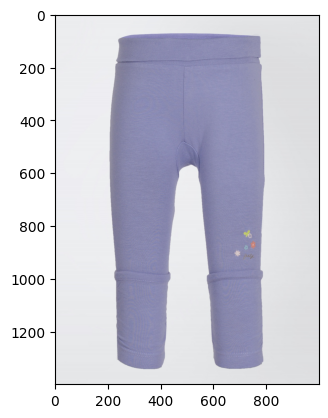

In [ ]:
cat = list(data_img['category'].unique())
showed = []

while len(cat) > 0:
    unique_id = np.random.choice(list(data_img['unique_id']))
    row = data_img[data_img.unique_id == unique_id]
    if row['category'].item() not in showed:
        showed.append(row['category'].item())
        cat.remove(row['category'].item())
        print(row['category'].item())
        plt.imshow(row['img'].item())
        plt.show()

### **B. VGG16**

VGG16 was pre-trained on the ImageNet database, which contains over a million images divided into 1000 classes. This pre-training allows VGG16 to be used as a base model for many computer vision tasks, including image classification, object detection, and more, using transfer learning techniques where the model pre-trained is finely tuned on a smaller or different dataset.

Despite its simplicity and efficiency, VGG16 is considered a very heavy model in terms of the number of parameters (around 138 million), which makes it computationally and memory intensive during training and inference. Later architectures, such as ResNet, sought to improve efficiency and performance by introducing concepts like residual connections.

In [ ]:
# Resizing images to fixed dimensions for CNN models like VGG16 and merges categorical data for direct use in ML training or validation
width = 160
height = 145
dim = (width, height)

data_vgg = pd.DataFrame({'unique_id': [], 'img': []})
a = []
b = []
for file_name in os.listdir(image_directory):
    a.append(file_name.split('.')[0])
    image = cv2.imread(image_directory + file_name, )
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)  # resized
    b.append(resized)
data_vgg['unique_id'] = a
data_vgg['img'] = b
data_vgg = data_vgg.merge(
    data_img[['category', 'category_encoded', 'unique_id']], on='unique_id')

print(data_vgg['img'][0].shape)
print(type(b))

(145, 160, 3)
<class 'list'>


In [ ]:
model_vgg16 = load_model('vgg16')
model_vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 145, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 145, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 145, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 72, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 72, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 72, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 36, 40, 128)       0     

In [ ]:
y_cat_num = data_vgg['category_encoded']
l_cat = list(data_vgg['category'].unique())
y = y_cat_num.values
NB_CLASSES = y.max() + 1
y_one_hot = to_categorical(y, num_classes=NB_CLASSES)

# Freeze the weights of the layers of the base model so as not to train them
for layer in model_vgg16.layers:
    layer.trainable = False

# Add new layers for custom classification
model_vgg16_finetuned = Sequential([
    model_vgg16,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NB_CLASSES, activation='softmax')
])

# Compile the model
model_vgg16_finetuned.compile(optimizer=Adam(learning_rate=1e-4),
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

In [ ]:
# Conversion of stored images into a NumPy array, required here for machine learning processing
X = np.asarray([i for i in data_vgg['img']])
X.shape

(1049, 145, 160, 3)

In [ ]:
# Train test split
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y_one_hot,
                                                  test_size=0.199,
                                                  stratify=y_one_hot,
                                                  random_state=42)
print(f"Shapes: {X_train.shape} and {X_val.shape}")

Shapes: (840, 145, 160, 3) and (209, 145, 160, 3)


In [ ]:
# Define the callback EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True)

# Train the model with the callback
vgg16_history = model_vgg16_finetuned.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # EarlyStopping will decide, even if the value is high here
    batch_size=32,
    callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 70s 3s/step - loss: 20.7367 - accuracy: 0.3833 - val_loss: 5.9499 - val_accuracy: 0.6699
Epoch 2/100
27/27 [==============================] - 72s 3s/step - loss: 5.5193 - accuracy: 0.7202 - val_loss: 5.0591 - val_accuracy: 0.7225
Epoch 3/100
27/27 [==============================] - 76s 3s/step - loss: 3.0994 - accuracy: 0.8107 - val_loss: 4.5959 - val_accuracy: 0.7225
Epoch 4/100
27/27 [==============================] - 67s 3s/step - loss: 1.3950 - accuracy: 0.8738 - val_loss: 4.1942 - val_accuracy: 0.7656
Epoch 5/100
27/27 [==============================] - 69s 3s/step - loss: 0.8122 - accuracy: 0.9167 - val_loss: 4.3867 - val_accuracy: 0.7751
Epoch 6/100
27/27 [==============================] - 68s 3s/step - loss: 0.8945 - accuracy: 0.9286 - val_loss: 4.2106 - val_accuracy: 0.7895
Epoch 7/100
27/27 [==============================] - 68s 3s/step - loss: 0.5399 - accuracy: 0.9393 - val_loss: 4.0745 - val_accuracy: 0.7895
Epoch 8/100


In [ ]:
# Evaluation
eval_result = model_vgg16_finetuned.evaluate(X_val, y_val)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

7/7 [==============================] - 16s 2s/step - loss: 3.8576 - accuracy: 0.7895
Test Loss: 3.857625722885132, Test Accuracy: 0.7894737124443054


In [ ]:
# Prediction on validation data
val_predictions = model_vgg16_finetuned.predict(X_val)
val_predictions_labels = val_predictions.argmax(axis=-1)

7/7 [==============================] - 14s 2s/step


In [ ]:
val_predictions = [
    val_prediction.flatten() for val_prediction in val_predictions
]
val_predictions = np.array(val_predictions)
print("Number of descriptors : ", val_predictions.shape)

Number of descriptors :  (209, 7)


In [ ]:
ARI_vgg, X_tsne_vgg, labels_vgg = ARI_fct(
    val_predictions,
    len(data_vgg['category'].unique()),
    val_predictions_labels,
    perplexity=35
)  # Tests with different perplexity values showed that 35 provides a good balance between preserving local and global data structures for this specific set

ARI :  1.0 time :  2.0


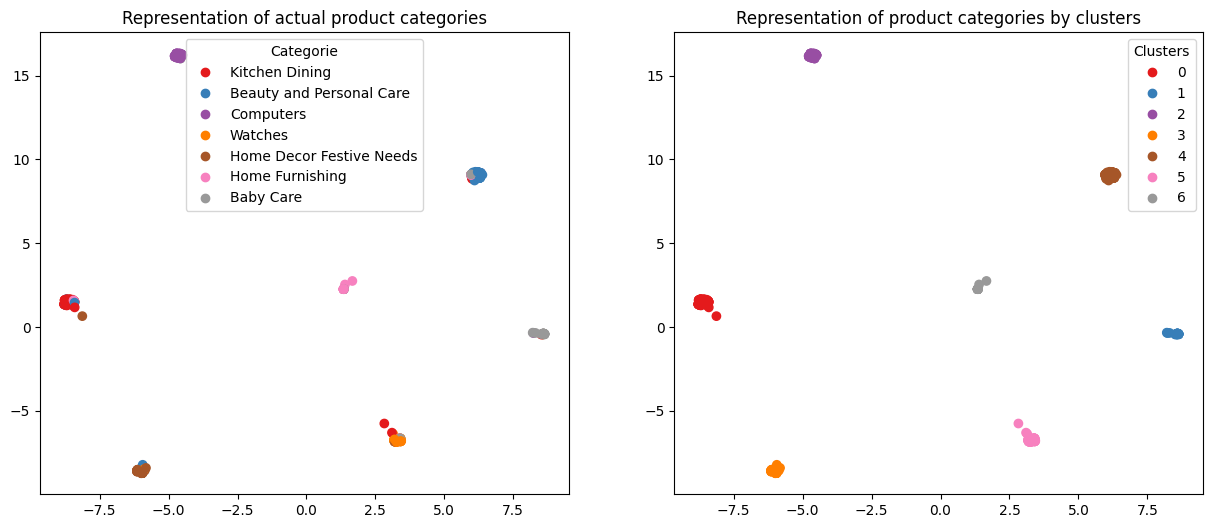

ARI :  1.0


In [ ]:
true_labels = np.argmax(y_val, axis=1)
TSNE_visu_fct(X_tsne_vgg, true_labels, labels_vgg, ARI_vgg)

In [ ]:
# Convert predictions to class indices
vgg16_predicted_classes = np.argmax(val_predictions, axis=1)
print(classification_report(true_labels, vgg16_predicted_classes))

              precision    recall  f1-score   support

           0       0.70      0.77      0.73        30
           1       0.69      0.73      0.71        30
           2       0.93      0.93      0.93        30
           3       0.71      0.73      0.72        30
           4       0.87      0.87      0.87        30
           5       0.88      0.76      0.81        29
           6       0.79      0.73      0.76        30

    accuracy                           0.79       209
   macro avg       0.79      0.79      0.79       209
weighted avg       0.79      0.79      0.79       209



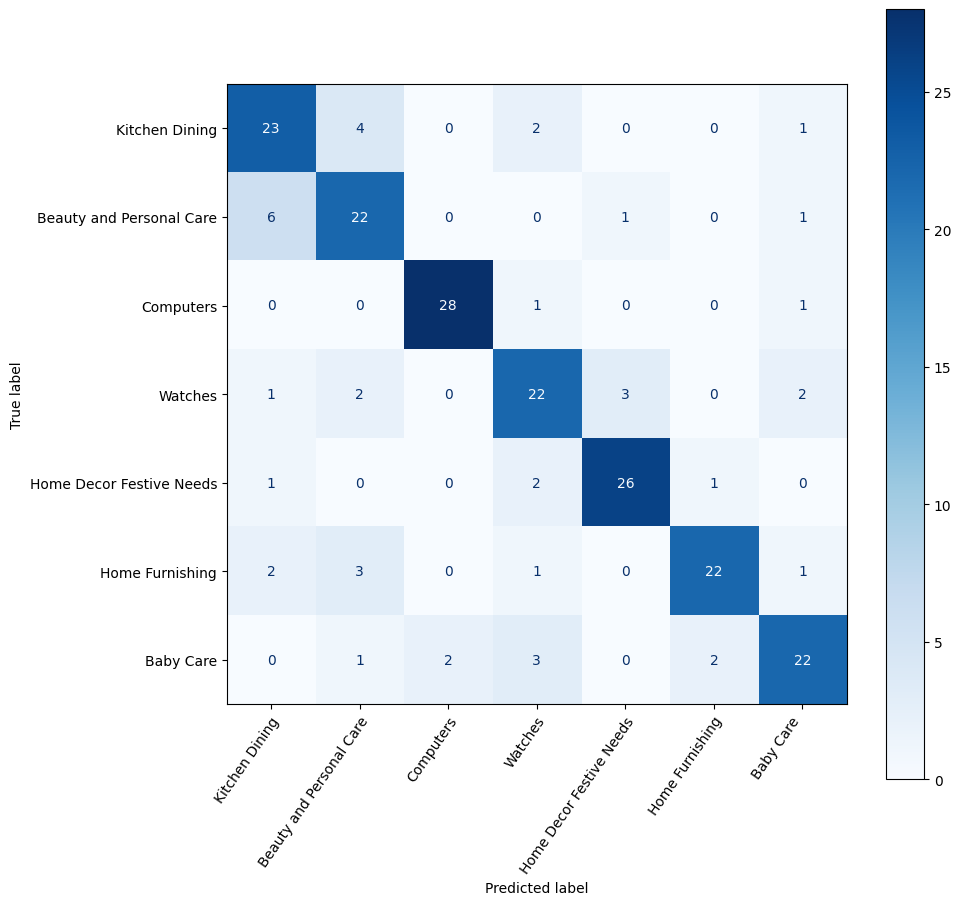

In [ ]:
confusion_matrix_plot(true_labels, vgg16_predicted_classes, l_cat)

- **High accuracy**: The finetuned VGG16 model achieves high overall accuracy, showcasing its ability to learn and generalize from the image data effectively.
- **Misclassification issues**: Despite the high accuracy, the confusion matrix indicates specific categories where the model confuses one for another, suggesting a need for targeted improvement.
- **Feature clustering**: The t-SNE visualization reveals decent feature separation with some overlap, indicating that while most categories are distinct, some are close enough to cause occasional misclassification.
- **Refinement opportunities**: Quick training times are encouraging, but the performance can be enhanced by addressing the overlaps in clusters, potentially through more nuanced data augmentation or by increasing the diversity of the training set.

### **C. ResNet**

In [ ]:
model_resnet = load_model('resnet')
model_resnet.summary()

94765736/94765736 [==============================] - 3s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 145, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 151, 166, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 73, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 73, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                      

In [ ]:
# Freeze the weights of the layers of the base model so as not to train them
for layer in model_resnet.layers:
    layer.trainable = False

# Add new layers for custom classification
model_resnet_finetuned = Sequential([
    model_resnet,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NB_CLASSES, activation='softmax')
])

# Compile the model
model_resnet_finetuned.compile(optimizer=Adam(learning_rate=1e-4),
                               loss='categorical_crossentropy',
                               metrics=['accuracy'])

In [ ]:
# Train the model with the callback
history = model_resnet_finetuned.fit(X_train,
                                     y_train,
                                     validation_data=(X_val, y_val),
                                     epochs=100,
                                     batch_size=32,
                                     callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 32s 1s/step - loss: 2.1815 - accuracy: 0.5619 - val_loss: 0.6677 - val_accuracy: 0.8038
Epoch 2/100
27/27 [==============================] - 27s 1s/step - loss: 0.4176 - accuracy: 0.8631 - val_loss: 0.5893 - val_accuracy: 0.8230
Epoch 3/100
27/27 [==============================] - 28s 1s/step - loss: 0.2049 - accuracy: 0.9369 - val_loss: 0.6060 - val_accuracy: 0.8230
Epoch 4/100
27/27 [==============================] - 27s 1s/step - loss: 0.1191 - accuracy: 0.9655 - val_loss: 0.6323 - val_accuracy: 0.8230
Epoch 5/100
27/27 [==============================] - 27s 1000ms/step - loss: 0.0591 - accuracy: 0.9810 - val_loss: 0.6549 - val_accuracy: 0.8134
Epoch 6/100
27/27 [==============================] - 27s 1s/step - loss: 0.0498 - accuracy: 0.9881 - val_loss: 0.6764 - val_accuracy: 0.8134
Epoch 7/100
27/27 [==============================] - 27s 1s/step - loss: 0.0404 - accuracy: 0.9893 - val_loss: 0.6587 - val_accuracy: 0.8038
Epoch 8/1

In [ ]:
# Evaluation
eval_result = model_resnet_finetuned.evaluate(X_val, y_val)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

7/7 [==============================] - 5s 757ms/step - loss: 0.5893 - accuracy: 0.8230
Test Loss: 0.589270293712616, Test Accuracy: 0.8229665160179138


In [ ]:
# Prediction on validation data
resnet_val_predictions = model_resnet_finetuned.predict(X_val)
resnet_val_predictions_labels = resnet_val_predictions.argmax(axis=-1)

7/7 [==============================] - 6s 712ms/step


In [ ]:
resnet_val_predictions = [
    resnet_val_prediction.flatten()
    for resnet_val_prediction in resnet_val_predictions
]
resnet_val_predictions = np.array(resnet_val_predictions)
print("Number of descriptors : ", resnet_val_predictions.shape)

Number of descriptors :  (209, 7)


In [ ]:
ARI_resnet, X_tsne_resnet, labels_resnet = ARI_fct(
    resnet_val_predictions,
    len(data_vgg['category'].unique()),
    resnet_val_predictions_labels,
    perplexity=35)

ARI :  0.9639 time :  1.0


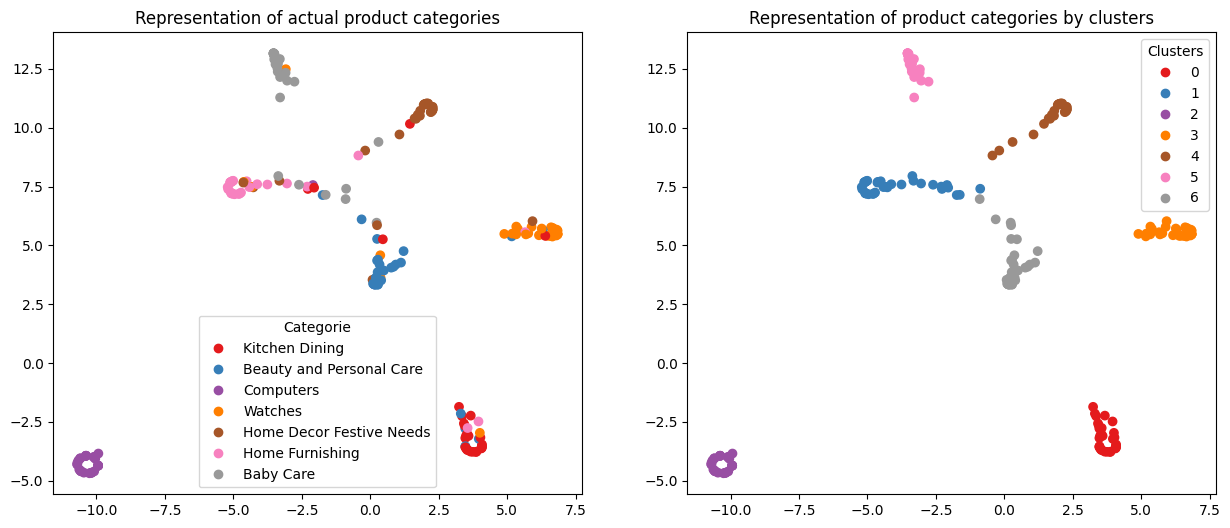

ARI :  0.9639


In [ ]:
TSNE_visu_fct(X_tsne_resnet, true_labels, labels_resnet, ARI_resnet)

In [ ]:
# Convert predictions to class indices
resnet_predicted_classes = np.argmax(resnet_val_predictions, axis=1)

print(classification_report(true_labels, resnet_predicted_classes))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81        30
           1       0.74      0.77      0.75        30
           2       0.94      0.97      0.95        30
           3       0.83      0.80      0.81        30
           4       0.89      0.80      0.84        30
           5       0.69      0.83      0.75        29
           6       0.96      0.77      0.85        30

    accuracy                           0.82       209
   macro avg       0.83      0.82      0.82       209
weighted avg       0.83      0.82      0.82       209



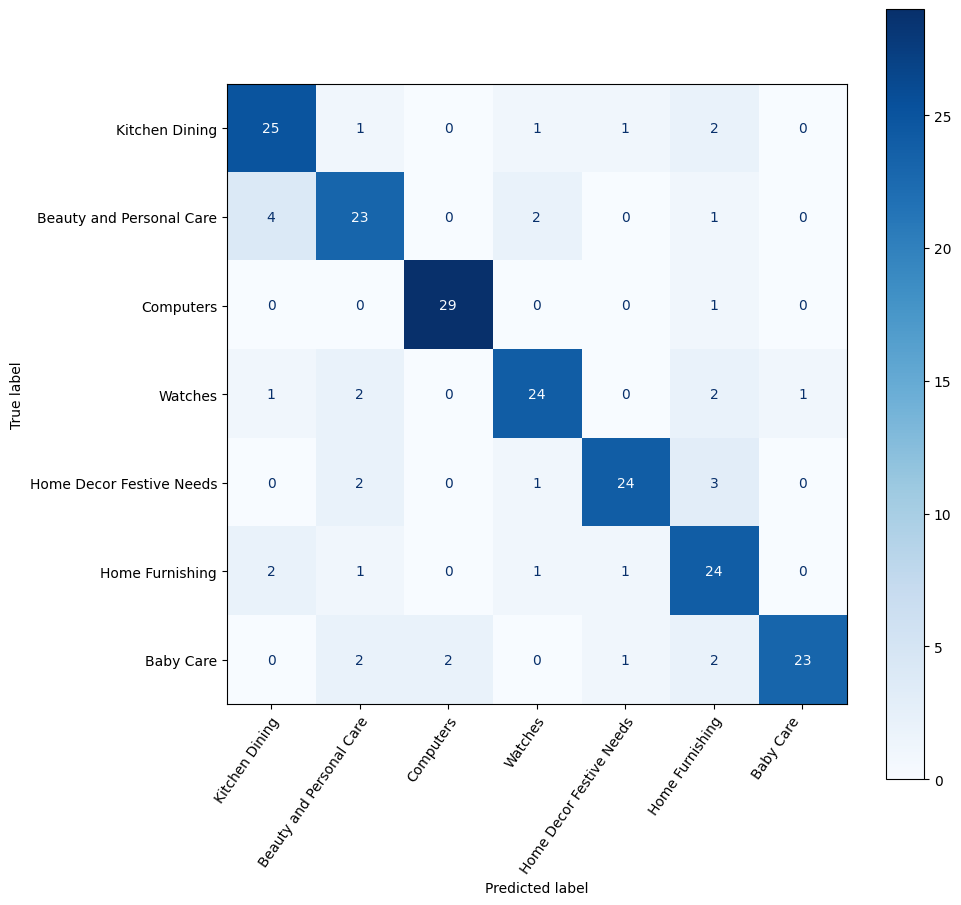

In [ ]:
confusion_matrix_plot(true_labels, resnet_predicted_classes, l_cat)

- **Overall performance**: The finetuned ResNet model demonstrates strong classification performance with high accuracy, evidenced by high precision, recall, and F1-scores across most categories.
- **Clustering accuracy**: The ARI score close to 1 indicates excellent agreement between the clusters formed by the model's predictions and the actual product categories.
- **Visualization insights**: The t-SNE visualization and confusion matrix reveal that while there's some confusion between similar categories, the model generally distinguishes well between different types of products.
- **Refinement potential**: Opportunities for further refinement are suggested by the confusion matrix, where focused improvements could be made in areas where the model shows a higher rate of misclassification.

### **D. Inception**

In [ ]:
model_inception = load_model('inception')
model_inception.summary()

87910968/87910968 [==============================] - 3s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 145, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 72, 79, 32)           864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 72, 79, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activatio

In [ ]:
# Freeze the weights of the layers of the base model so as not to train them
for layer in model_inception.layers:
    layer.trainable = False

# Add new layers for custom classification
model_inception_finetuned = Sequential([
    model_inception,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NB_CLASSES, activation='softmax')
])

# Compile the model
model_inception_finetuned.compile(optimizer=Adam(learning_rate=1e-4),
                                  loss='categorical_crossentropy',
                                  metrics=['accuracy'])

In [ ]:
# Train the model with the callback
inception_history = model_inception_finetuned.fit(X_train,
                                                  y_train,
                                                  validation_data=(X_val,
                                                                   y_val),
                                                  epochs=100,
                                                  batch_size=32,
                                                  callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 20s 543ms/step - loss: 61.5791 - accuracy: 0.2250 - val_loss: 5.4031 - val_accuracy: 0.2727
Epoch 2/100
27/27 [==============================] - 12s 460ms/step - loss: 3.2024 - accuracy: 0.2107 - val_loss: 2.0940 - val_accuracy: 0.2010
Epoch 3/100
27/27 [==============================] - 12s 452ms/step - loss: 1.9422 - accuracy: 0.1595 - val_loss: 1.9539 - val_accuracy: 0.1962
Epoch 4/100
27/27 [==============================] - 12s 463ms/step - loss: 1.9156 - accuracy: 0.1893 - val_loss: 1.9062 - val_accuracy: 0.1770
Epoch 5/100
27/27 [==============================] - 12s 463ms/step - loss: 1.8899 - accuracy: 0.1833 - val_loss: 1.8705 - val_accuracy: 0.2105
Epoch 6/100
27/27 [==============================] - 12s 459ms/step - loss: 1.8864 - accuracy: 0.2179 - val_loss: 2.0371 - val_accuracy: 0.2201
Epoch 7/100
27/27 [==============================] - 12s 459ms/step - loss: 1.8860 - accuracy: 0.1893 - val_loss: 1.9148 - val_accuracy

In [ ]:
# Evaluation
eval_result = model_inception_finetuned.evaluate(X_val, y_val)
print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

7/7 [==============================] - 2s 327ms/step - loss: 1.8705 - accuracy: 0.2105
Test Loss: 1.8704684972763062, Test Accuracy: 0.21052631735801697


In [ ]:
# Prediction on validation data
inception_val_predictions = model_inception_finetuned.predict(X_val)
inception_val_predictions_labels = inception_val_predictions.argmax(axis=-1)

7/7 [==============================] - 4s 358ms/step


In [ ]:
inception_val_predictions = [
    inception_val_prediction.flatten()
    for inception_val_prediction in inception_val_predictions
]
inception_val_predictions = np.array(inception_val_predictions)
print("Number of descriptors : ", inception_val_predictions.shape)

Number of descriptors :  (209, 7)


In [ ]:
ARI_inception, X_tsne_inception, labels_inception = ARI_fct(
    inception_val_predictions,
    len(data_vgg['category'].unique()),
    inception_val_predictions_labels,
    perplexity=35)

ARI :  0.2977 time :  2.0


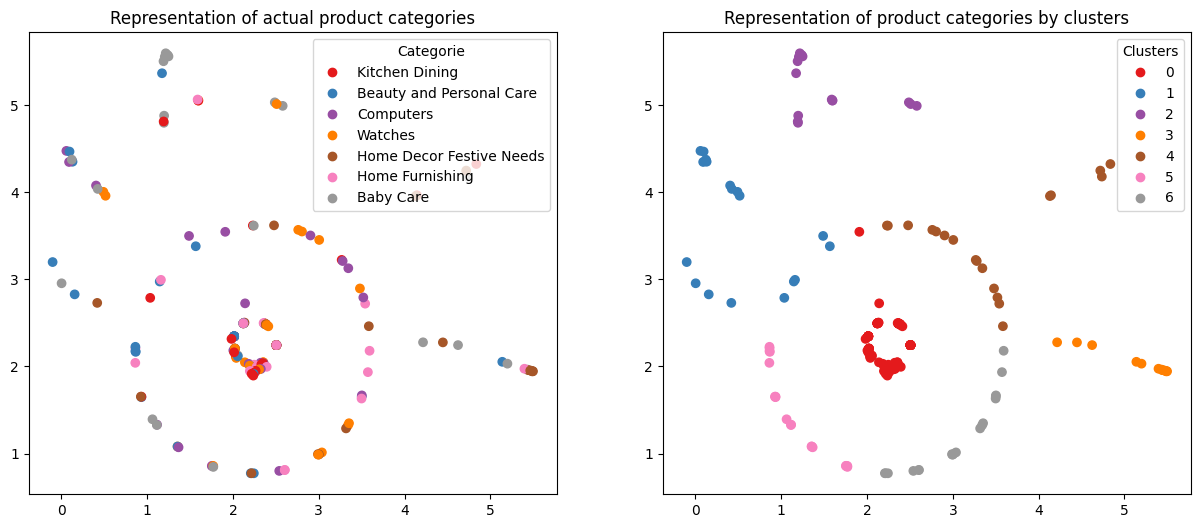

ARI :  0.2977


In [ ]:
TSNE_visu_fct(X_tsne_inception, true_labels, labels_inception, ARI_inception)

In [ ]:
# Convert predictions to class indices
inception_predicted_classes = np.argmax(inception_val_predictions, axis=1)

print(classification_report(true_labels, inception_predicted_classes))

              precision    recall  f1-score   support

           0       0.20      0.03      0.06        30
           1       0.00      0.00      0.00        30
           2       0.17      1.00      0.30        30
           3       0.00      0.00      0.00        30
           4       0.50      0.20      0.29        30
           5       0.00      0.00      0.00        29
           6       0.58      0.23      0.33        30

    accuracy                           0.21       209
   macro avg       0.21      0.21      0.14       209
weighted avg       0.21      0.21      0.14       209



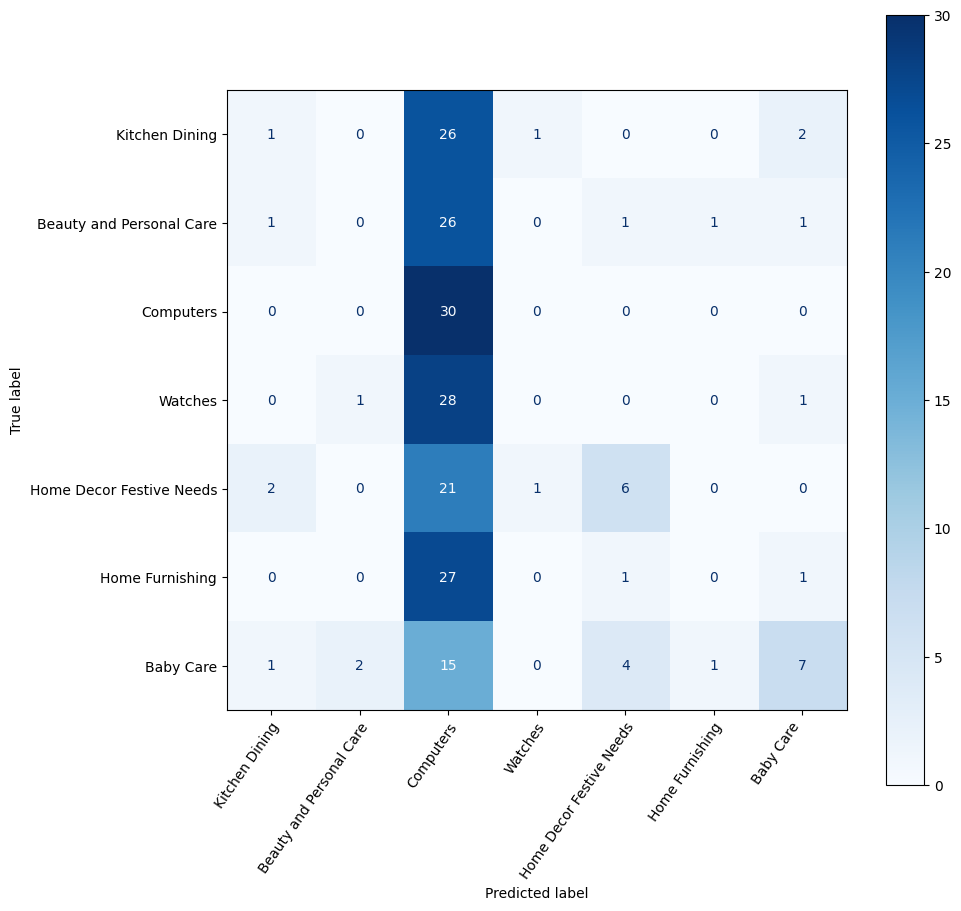

In [ ]:
confusion_matrix_plot(true_labels, inception_predicted_classes, l_cat)

- **Performance variability**: The finetuned Inception model shows inconsistent performance across categories, with some categories achieving high accuracy, while others are prone to misclassification.
- **Clustering precision**: The ARI score indicates that the clustering is not very precise, suggesting that the model's features for different categories are not as well separated as they could be.
- **Potential overfitting**: Given the perfect scores in some categories and poor performance in others, there could be an issue of overfitting to certain features within the dataset, necessitating a review of the model's complexity and regularization techniques.

### **E. Basic and advanced data augmentation on ResNet model**

Based on the results provided for VGG16, ResNet and Inception models, we would recommend focusing on improving the ResNet model :<br>
- *Higher overall performance*: ResNet has the highest accuracy at 0.80, showing a better grasp of the dataset than Inception and VGG16.<br>
- *Consistent Performance Across Categories*: ResNet maintains some level of predictive ability across all categories, without any scoring zero in precision or recall.<br>
- *Opportunity for data augmentation*: ResNet's solid base performance makes it a prime candidate for further improvement via data augmentation to enhance overall accuracy.<br><br>

Data augmentation consists of generating new training data from existing data, by various transformations (rotate, zoom, shift, flip...) randomly to reduce overfitting and improve the generalization of the model.

In [ ]:
# Freeze the weights of the layers of the base model so as not to train them
for layer in model_resnet.layers:
    layer.trainable = False

# Add new layers for custom classification
model_resnet_basic_finetuned = Sequential([
    model_resnet,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NB_CLASSES, activation='softmax')
])

# Compile the model
model_resnet_basic_finetuned.compile(optimizer=Adam(learning_rate=1e-4),
                                     loss='categorical_crossentropy',
                                     metrics=['accuracy'])

In [ ]:
# Define an image data generator with basic augmentations
datagen_basic = ImageDataGenerator(horizontal_flip=True,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   fill_mode='nearest')

# Fit the generator to your data
datagen_basic.fit(X_train)

In [ ]:
# Training the model with the basic augmentation
history_basic = model_resnet_basic_finetuned.fit_generator(
    datagen_basic.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    callbacks=[early_stopping])

<ipython-input-76-a800fc347781>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history_basic = model_resnet_basic_finetuned.fit_generator(


Epoch 1/100
26/26 [==============================] - 35s 1s/step - loss: 2.3391 - accuracy: 0.5297 - val_loss: 0.9339 - val_accuracy: 0.7847
Epoch 2/100
26/26 [==============================] - 28s 1s/step - loss: 1.0073 - accuracy: 0.7054 - val_loss: 0.7284 - val_accuracy: 0.7560
Epoch 3/100
26/26 [==============================] - 28s 1s/step - loss: 0.6760 - accuracy: 0.7797 - val_loss: 0.7285 - val_accuracy: 0.7608
Epoch 4/100
26/26 [==============================] - 28s 1s/step - loss: 0.6106 - accuracy: 0.8007 - val_loss: 0.6343 - val_accuracy: 0.8086
Epoch 5/100
26/26 [==============================] - 28s 1s/step - loss: 0.4779 - accuracy: 0.8428 - val_loss: 0.7136 - val_accuracy: 0.8086
Epoch 6/100
26/26 [==============================] - 29s 1s/step - loss: 0.4295 - accuracy: 0.8490 - val_loss: 0.6793 - val_accuracy: 0.8278
Epoch 7/100
26/26 [==============================] - 32s 1s/step - loss: 0.3460 - accuracy: 0.8861 - val_loss: 0.6841 - val_accuracy: 0.8421
Epoch 8/100
2

In [ ]:
# Evaluation
eval_result_basic = model_resnet_basic_finetuned.evaluate(X_val, y_val)
print(
    f"Test Loss: {eval_result_basic[0]}, Test Accuracy: {eval_result_basic[1]}"
)

7/7 [==============================] - 5s 685ms/step - loss: 0.6087 - accuracy: 0.8517
Test Loss: 0.6087108850479126, Test Accuracy: 0.8516746163368225


In [ ]:
# Prediction on validation data
resnet_val_predictions_basic = model_resnet_basic_finetuned.predict(X_val)
resnet_val_predictions_basic_labels = resnet_val_predictions_basic.argmax(
    axis=-1)

7/7 [==============================] - 6s 680ms/step


In [ ]:
resnet_val_predictions_basic = [
    resnet_val_predictions_b.flatten()
    for resnet_val_predictions_b in resnet_val_predictions_basic
]
resnet_val_predictions_basic = np.array(resnet_val_predictions_basic)
print("Number of descriptors : ", resnet_val_predictions_basic.shape)

Number of descriptors :  (209, 7)


In [ ]:
ARI_resnet_basic, X_tsne_resnet_basic, labels_resnet_basic = ARI_fct(
    resnet_val_predictions_basic,
    len(data_vgg['category'].unique()),
    resnet_val_predictions_basic_labels,
    perplexity=35)

ARI :  0.9668 time :  4.0


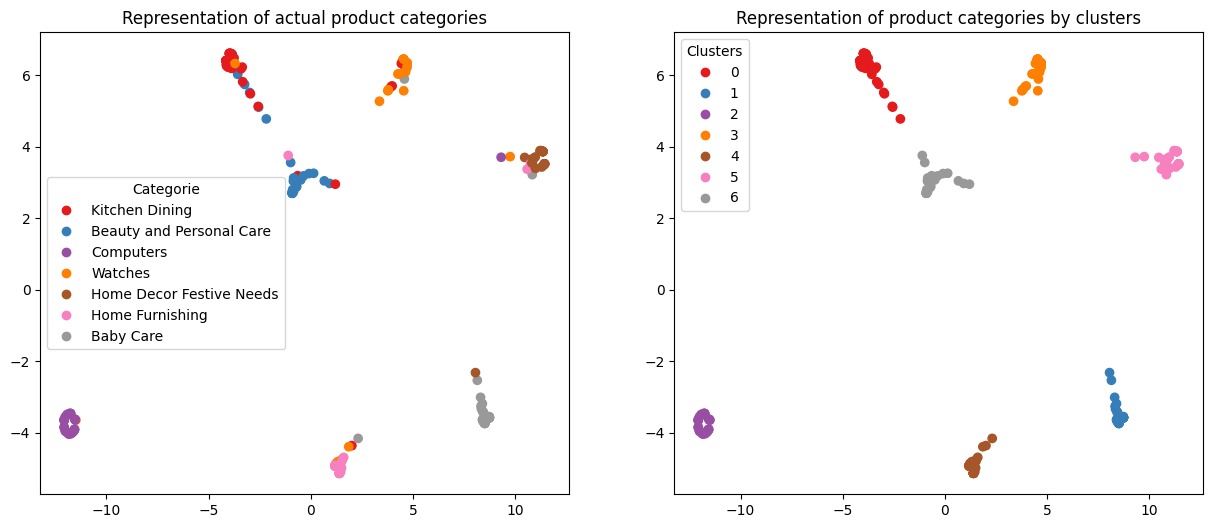

ARI :  0.9668


In [ ]:
TSNE_visu_fct(X_tsne_resnet_basic, true_labels, labels_resnet_basic,
              ARI_resnet_basic)

In [ ]:
# Convert predictions to class indices
resnet_basic_predicted_classes = np.argmax(resnet_val_predictions_basic,
                                           axis=1)

print(classification_report(true_labels, resnet_basic_predicted_classes))

              precision    recall  f1-score   support

           0       0.78      0.83      0.81        30
           1       0.85      0.77      0.81        30
           2       0.94      0.97      0.95        30
           3       0.80      0.80      0.80        30
           4       0.82      0.90      0.86        30
           5       0.82      0.79      0.81        29
           6       0.96      0.90      0.93        30

    accuracy                           0.85       209
   macro avg       0.85      0.85      0.85       209
weighted avg       0.85      0.85      0.85       209



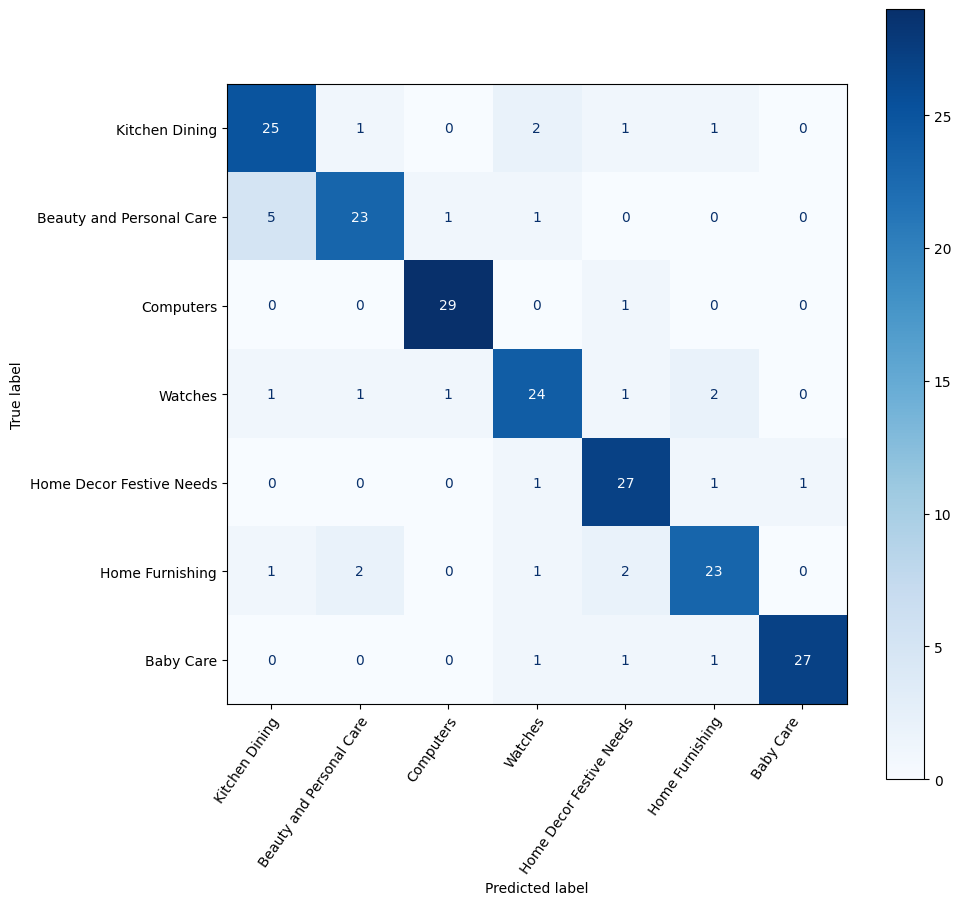

In [ ]:
confusion_matrix_plot(true_labels, resnet_basic_predicted_classes, l_cat)

- **Enhanced separation**: The finetuned ResNet model with basic data augmentation displays improved category separation, as seen in the t-SNE visualization, resulting in more defined clusters.
Consistent Performance: High scores in precision, recall, and F1 across most categories reflect the model's consistent performance after implementing data augmentation.
- **Precise clustering**: The ARI score near 1 signifies the model's predictions closely align with the true labels, underscoring the effectiveness of data augmentation.
- **Reduced misclassification**: While the confusion matrix points to a decrease in misclassification rates, indicating better generalization, there are still specific categories, particularly 'Baby Care', that could benefit from additional fine-tuning.

****

In [85]:
# Freeze the weights of the layers of the base model so as not to train them
for layer in model_resnet.layers:
    layer.trainable = False

# Add new layers for custom classification
model_resnet_adv_finetuned = Sequential([
    model_resnet,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(NB_CLASSES, activation='softmax')
])

# Compile the model
model_resnet_adv_finetuned.compile(optimizer=Adam(learning_rate=1e-4),
                                   loss='categorical_crossentropy',
                                   metrics=['accuracy'])

In [86]:
# Define an image data generator with advanced augmentations
datagen_advanced = ImageDataGenerator(horizontal_flip=True,
                                      vertical_flip=True,
                                      rotation_range=30,
                                      zoom_range=0.3,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.15,
                                      fill_mode='reflect')

# Fit the generator to your data
datagen_advanced.fit(X_train)

In [87]:
# Training the model with the advanced augmentation
history_advanced = model_resnet_adv_finetuned.fit_generator(
    datagen_advanced.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    steps_per_epoch=len(X_train) // 32,
    epochs=100,
    callbacks=[early_stopping])

26/26 [==============================] - 34s 1s/step - loss: 2.7515 - accuracy: 0.3775 - val_loss: 0.8881 - val_accuracy: 0.7177
Epoch 2/100
26/26 [==============================] - 28s 1s/step - loss: 1.1596 - accuracy: 0.5941 - val_loss: 0.7257 - val_accuracy: 0.7464
Epoch 3/100
26/26 [==============================] - 28s 1s/step - loss: 0.9777 - accuracy: 0.6634 - val_loss: 0.7205 - val_accuracy: 0.8086
Epoch 4/100
26/26 [==============================] - 30s 1s/step - loss: 0.8882 - accuracy: 0.7054 - val_loss: 0.6915 - val_accuracy: 0.8038
Epoch 5/100
26/26 [==============================] - 29s 1s/step - loss: 0.7999 - accuracy: 0.7141 - val_loss: 0.7680 - val_accuracy: 0.7847
Epoch 6/100
26/26 [==============================] - 29s 1s/step - loss: 0.7716 - accuracy: 0.7314 - val_loss: 0.6742 - val_accuracy: 0.8134
Epoch 7/100
26/26 [==============================] - 28s 1s/step - loss: 0.6989 - accuracy: 0.7587 - val_loss: 0.7152 - val_accuracy: 0.7895
Epoch 8/100
26/26 [======

In [88]:
# Evaluation
eval_result_adavanced = model_resnet_adv_finetuned.evaluate(X_val, y_val)
print(
    f"Test Loss: {eval_result_adavanced[0]}, Test Accuracy: {eval_result_adavanced[1]}"
)

7/7 [==============================] - 5s 764ms/step - loss: 0.6574 - accuracy: 0.8182
Test Loss: 0.6573934555053711, Test Accuracy: 0.8181818127632141


In [89]:
# Prediction on validation data
resnet_val_predictions_advanced = model_resnet_adv_finetuned.predict(X_val)
resnet_val_predictions_advanced_labels = resnet_val_predictions_advanced.argmax(
    axis=-1)

7/7 [==============================] - 6s 707ms/step


In [90]:
resnet_val_predictions_advanced = [
    resnet_val_predictions_a.flatten()
    for resnet_val_predictions_a in resnet_val_predictions_advanced
]
resnet_val_predictions_advanced = np.array(resnet_val_predictions_advanced)
print("Number of descriptors : ", resnet_val_predictions_advanced.shape)

Number of descriptors :  (209, 7)


In [91]:
ARI_resnet_advanced, X_tsne_resnet_advanced, labels_resnet_advanced = ARI_fct(
    resnet_val_predictions_advanced,
    len(data_vgg['category'].unique()),
    resnet_val_predictions_advanced_labels,
    perplexity=35)

ARI :  0.9666 time :  3.0


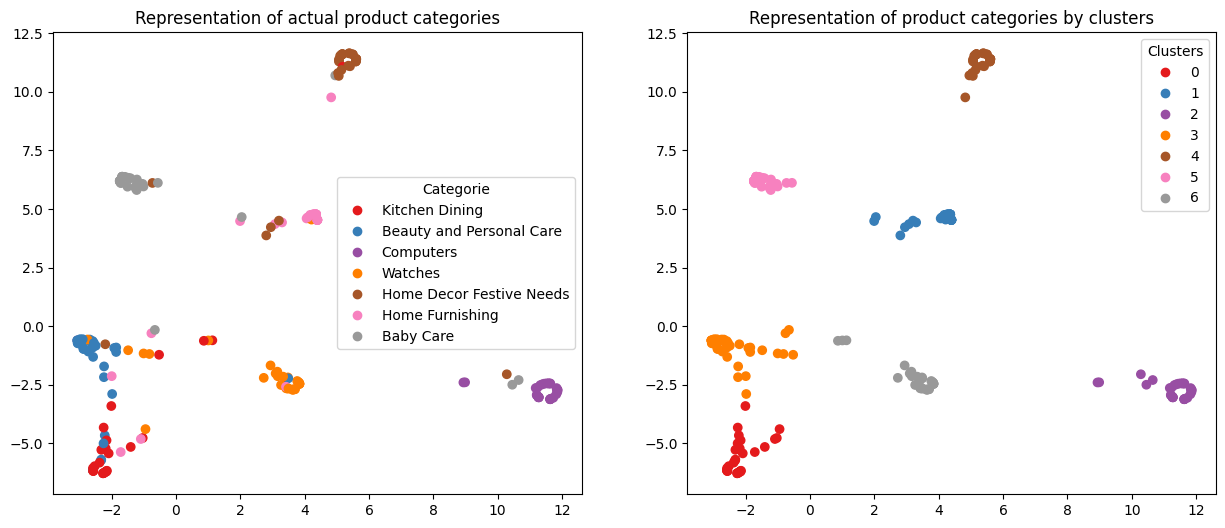

ARI :  0.9666


In [92]:
TSNE_visu_fct(X_tsne_resnet_advanced, true_labels, labels_resnet_advanced,
              ARI_resnet_advanced)

In [93]:
# Convert predictions to class indices
resnet_advanced_predicted_classes = np.argmax(resnet_val_predictions_advanced,
                                              axis=1)
print(classification_report(true_labels, resnet_advanced_predicted_classes))

              precision    recall  f1-score   support

           0       0.76      0.83      0.79        30
           1       0.73      0.80      0.76        30
           2       0.91      0.97      0.94        30
           3       0.77      0.80      0.79        30
           4       0.86      0.80      0.83        30
           5       0.81      0.72      0.76        29
           6       0.92      0.80      0.86        30

    accuracy                           0.82       209
   macro avg       0.82      0.82      0.82       209
weighted avg       0.82      0.82      0.82       209



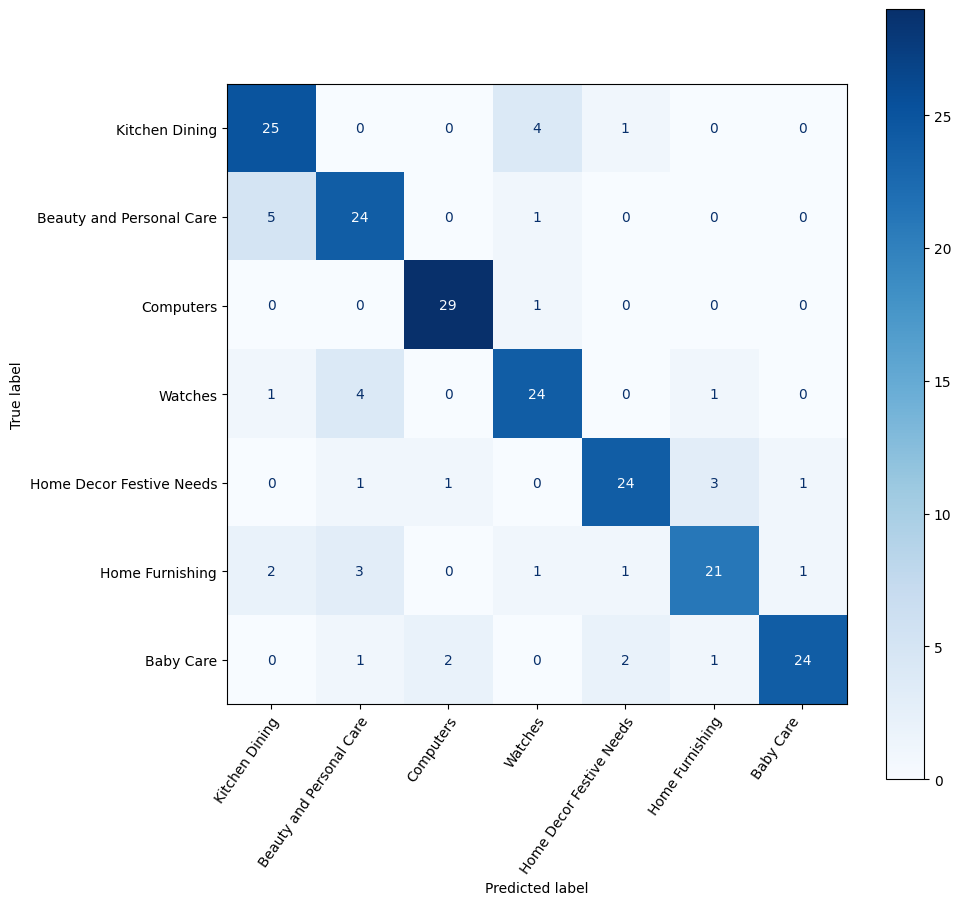

In [94]:
confusion_matrix_plot(true_labels, resnet_advanced_predicted_classes, l_cat)

- **Overfitting with advanced augmentation**: Sometimes, advanced data augmentation can introduce too much variability, causing the model to learn from noisy or less representative features. This can make the model less generalizable to new data, reflected in a poorer performance on the validation set.
- **Appropriateness to the dataset**: The effectiveness of augmentation techniques can vary based on the dataset. In this case, the basic augmentation methods might be more aligned with the natural variations in your image data, leading to better performance.
- **Balance of augmentation**: Basic augmentation may provide a better balance by introducing enough variability to improve generalization without confusing the model with overly augmented features.